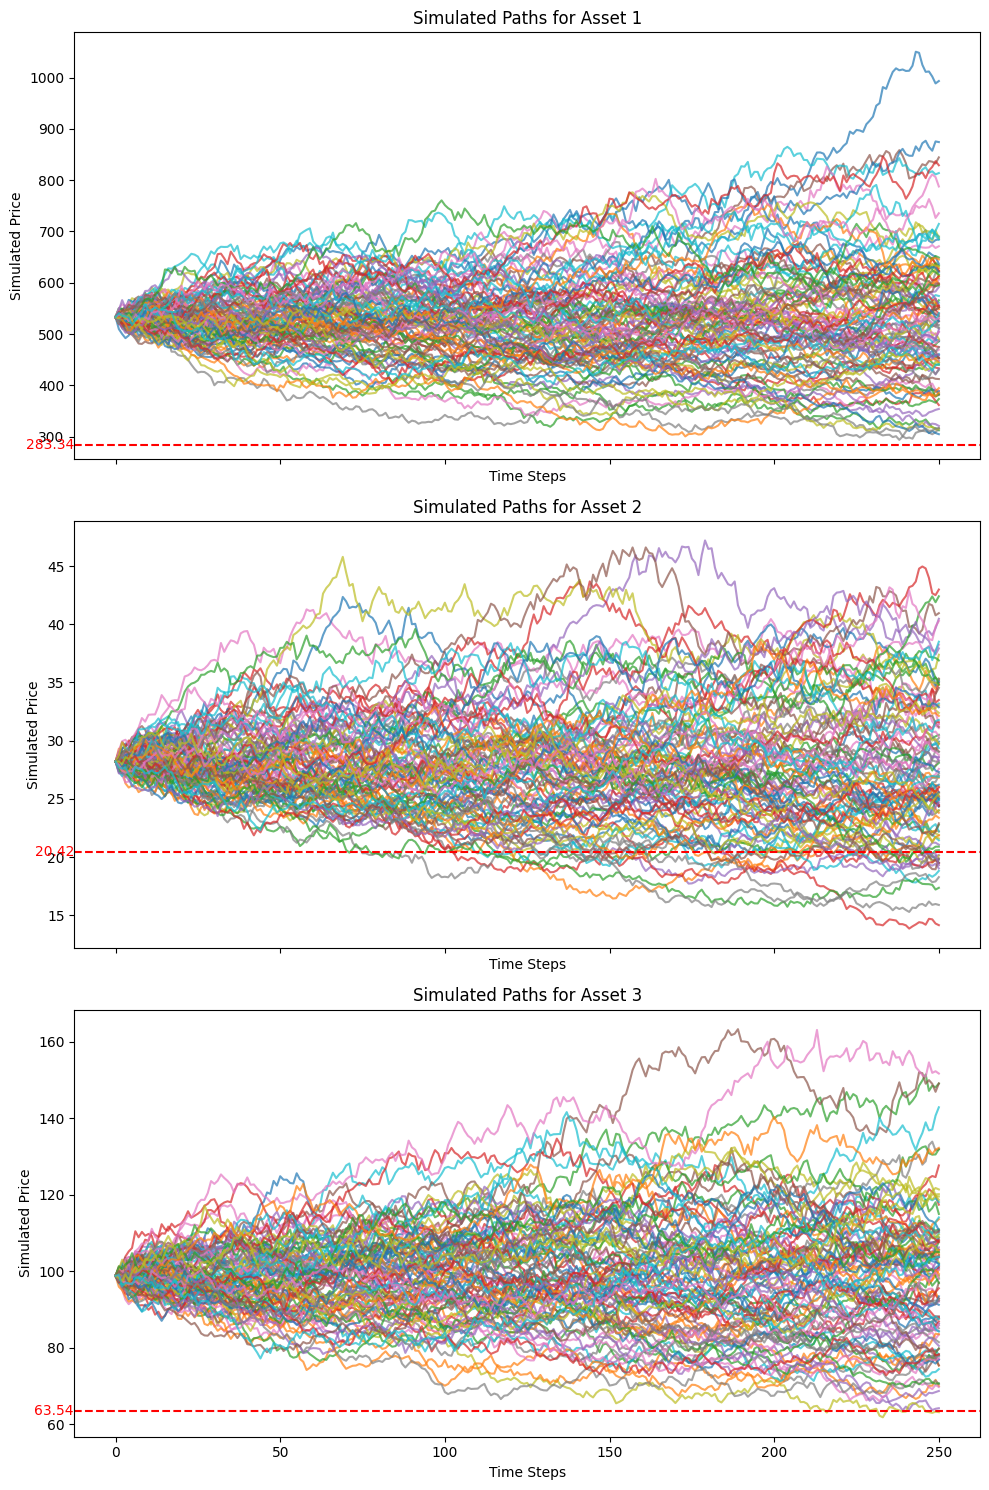

In [1]:
from GBM import MultiBS
import numpy as np

multi_bs = MultiBS()

forward_simulation = multi_bs.simulate_multi_GBM_antithetic(T=1, M=10_000)
v, sigma = multi_bs.calibrate_model(forward_simulation)
simul = multi_bs.simulate_multi_GBM_exact(T=1, M=100)
multi_bs.plot(simul)

In [2]:
import pandas as pd
start_date="2023-08-23"

start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

# Slice the historical data from start_date onwards
historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index:].values
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index:].values
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index:].values
historical_prices = np.column_stack([historical_prices_1, historical_prices_2, historical_prices_3])
historical_prices[0, :]

array([480.22924805,  34.61804962, 107.69082642])

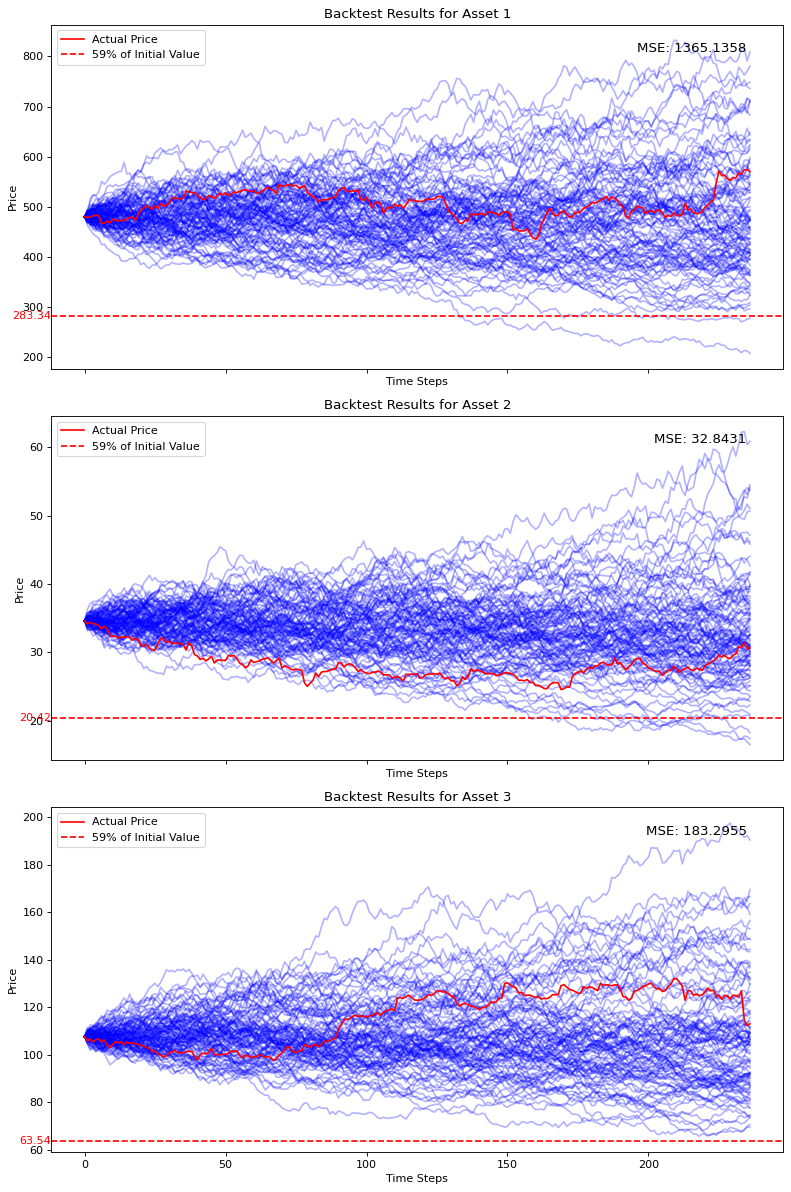

Mean Squared Error (MSE) for each asset: [1365.13581605   32.84307839  183.2955477 ]
Root Mean Squared Error (RMSE) for each asset: [36.9477444   5.7308881  13.53866861]


array([1365.13581605,   32.84307839,  183.2955477 ])

In [3]:
multi_bs.backtest(M=100)

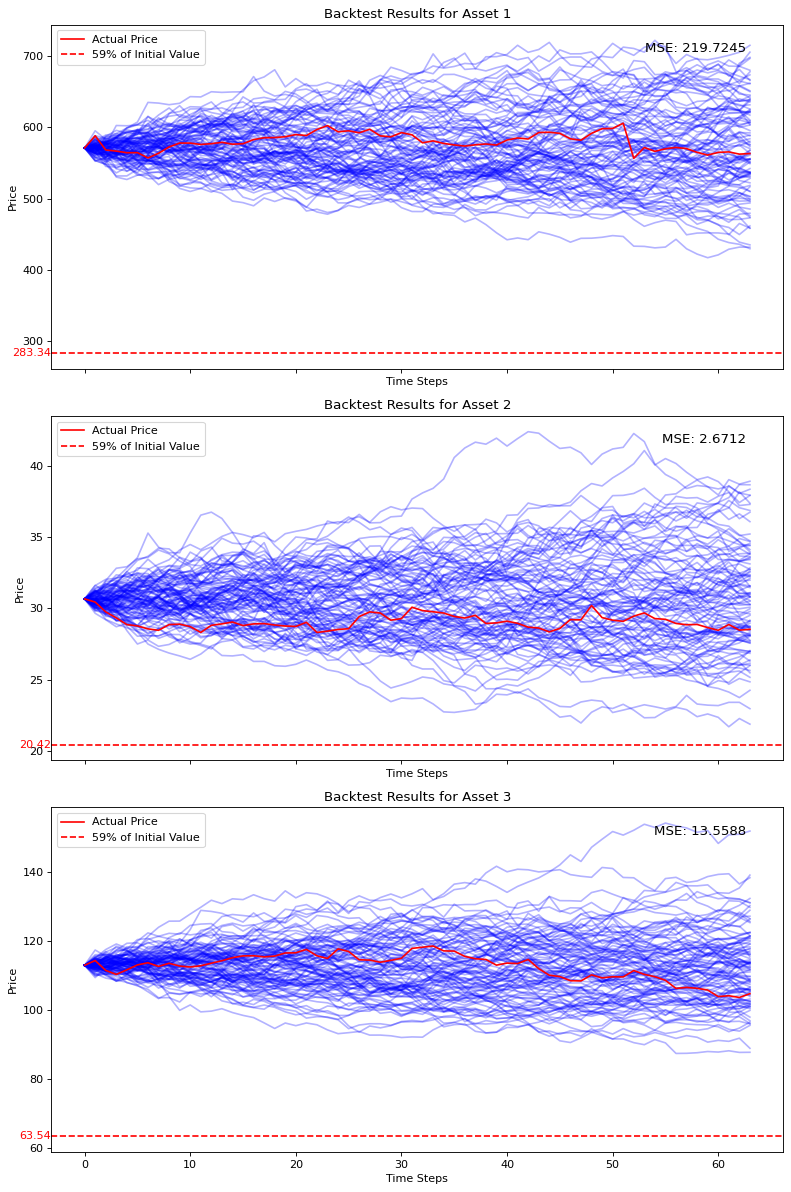

Mean Squared Error (MSE) for each asset: [219.72453688   2.67124381  13.55884921]
Root Mean Squared Error (RMSE) for each asset: [14.82310821  1.63439402  3.68223427]


array([219.72453688,   2.67124381,  13.55884921])

In [4]:
multi_bs.backtest(M=100, start_date="2024-08-01", end_date="2024-10-30")

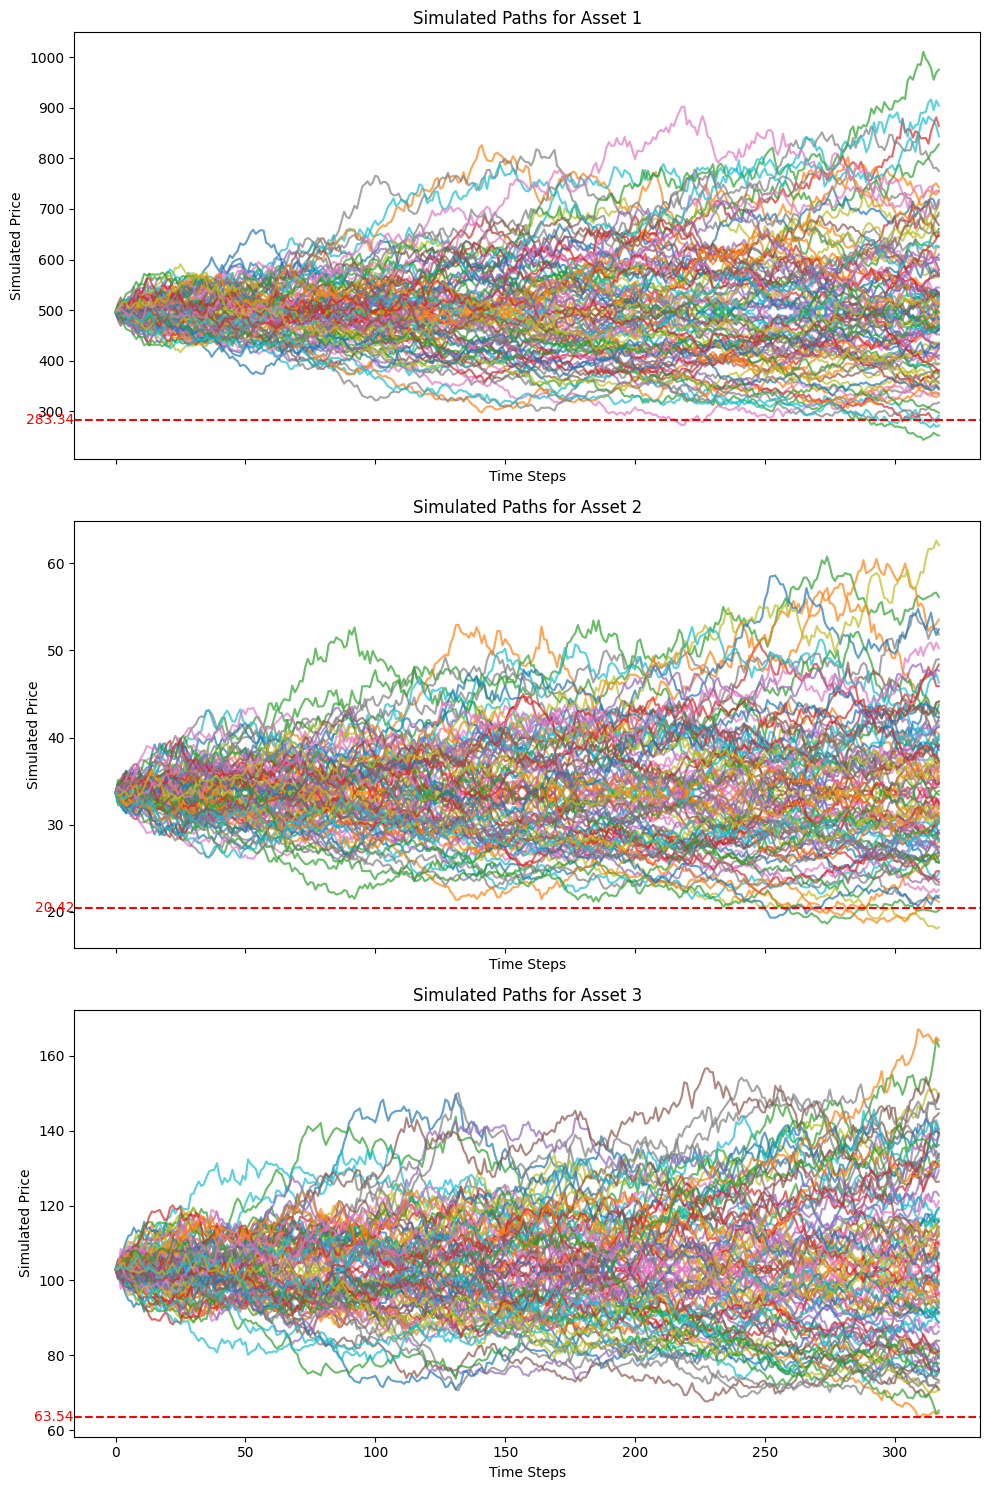

In [5]:
simul = multi_bs.simulate_multi_GBM_antithetic(T=317/250, M=100)
multi_bs.plot(simul)

In [6]:
start_date="2023-08-23"
start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index]
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index]
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index]
S0 = np.array([historical_prices_1, historical_prices_2, historical_prices_3])
print(S0)

[480.22924805  34.61804962 107.69082642]


In [7]:
from payoff import CallablePayoff
from tqdm import tqdm

payoff = CallablePayoff(0, r=0.0419, S0=S0)

epochs = 100
with tqdm(total=epochs, desc="Training Progress") as pbar:
    for epoch in range(epochs):
        path = multi_bs.simulate_multi_GBM_antithetic(T=317*multi_bs.dt, M=1_000,S0=S0) # 317 business days from initial fixing to final fixing
        path = np.log(path) # in asset, timestep, path
        # (path #, asset #, timestep #)
        path = path.transpose(2, 0, 1)
        losses = payoff.minimise_over_path(path)
        pbar.set_postfix({'Worst loss': max(losses), 
                            'Best Loss': min(losses)})
        pbar.update(1)

path = multi_bs.simulate_multi_GBM_antithetic(T=317*multi_bs.dt, M=10_000,S0=S0)
path = np.log(path) 
path = path.transpose(2, 0, 1)
x = payoff.evaluate_payoff(path, True)
print(x)

Training Progress: 100%|██████████| 100/100 [00:03<00:00, 30.84it/s, Worst loss=5.51e+3, Best Loss=5.39e+3]


tensor([[968.8704],
        [958.3982],
        [948.4916],
        ...,
        [958.3982],
        [958.3982],
        [958.3982]])


In [8]:
x.mean()

tensor(922.4986)

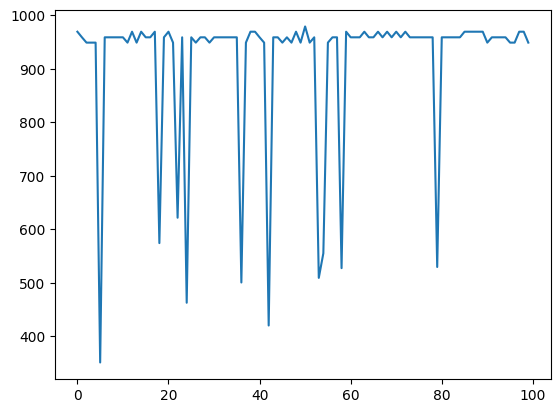

In [9]:
import matplotlib.pyplot as plt
plt.plot(x[:100])

In [10]:
x = payoff.evaluate_payoff(path, False)
print(x)
print(x.mean())

tensor([[1072.4437],
        [1072.4437],
        [1072.4437],
        ...,
        [1072.4437],
        [1072.4437],
        [1072.4437]])
tensor(1029.5812)


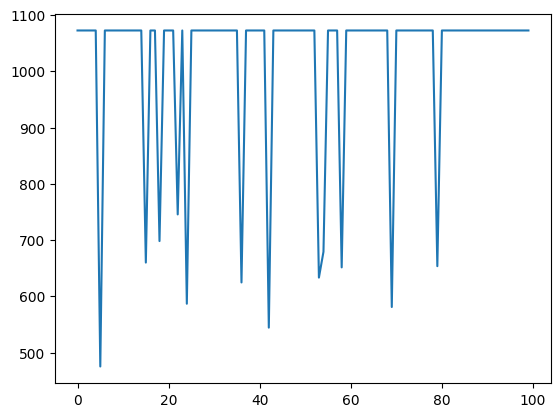

In [11]:
import matplotlib.pyplot as plt
plt.plot(x[:100])

In [12]:
delta = multi_bs.calculate_delta(pay_off=payoff, T=317*multi_bs.dt, h=0.01, S0=S0)
print(delta)

[0.25580683 0.32172557 0.40968651]


In [14]:

gamma = multi_bs.calculate_gamma(pay_off=payoff, T=317*multi_bs.dt, h=0.01)

In [15]:
print(f"Delta: {delta}, \nGamma: \n{gamma}")

Delta: [0.25580683 0.32172557 0.40968651], 
Gamma: 
[[ 0.00688764 -0.07032398  0.28654535]
 [-0.03876839 -2.10028093  0.53739239]
 [-0.09707985  0.39341055 -0.45777427]]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate log-spaced values for h between 0.001 and 0.05
h_values = np.logspace(-3, -1, num=1000)  # 5 values from 0.001 to approximately 0.05
T = 1.5
M = 1000
deltas = []
gammas = []

# Calculate Delta and Gamma for each h value
for h in h_values:
    delta = multi_bs.calculate_delta(T, M, h)
    gamma = multi_bs.calculate_gamma(T, M, h)
    deltas.append(delta)
    gammas.append(gamma)

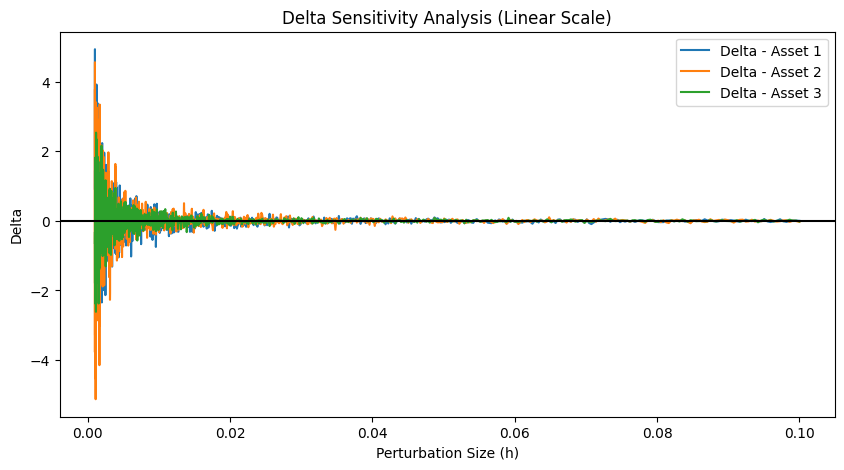

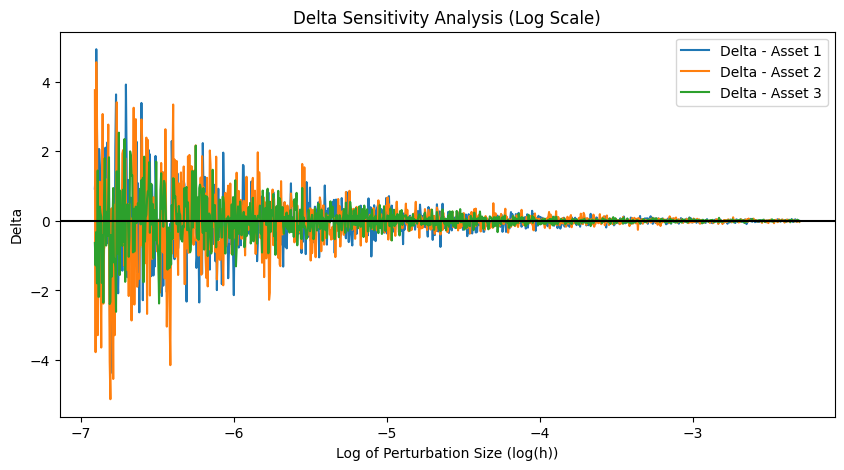

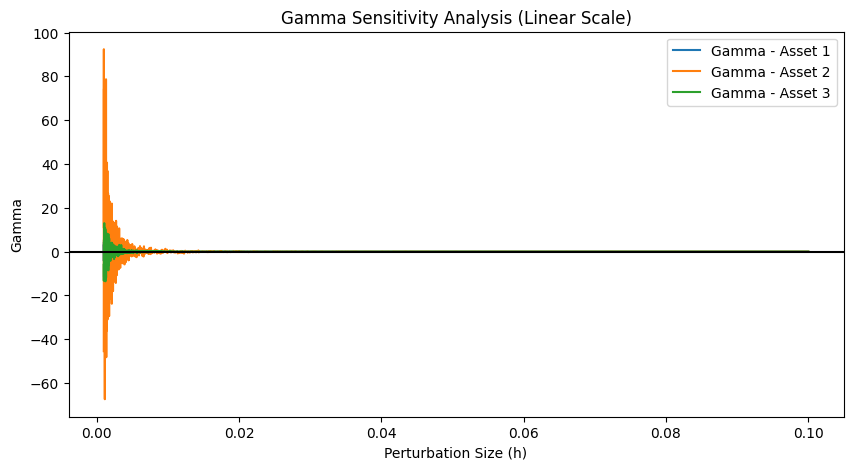

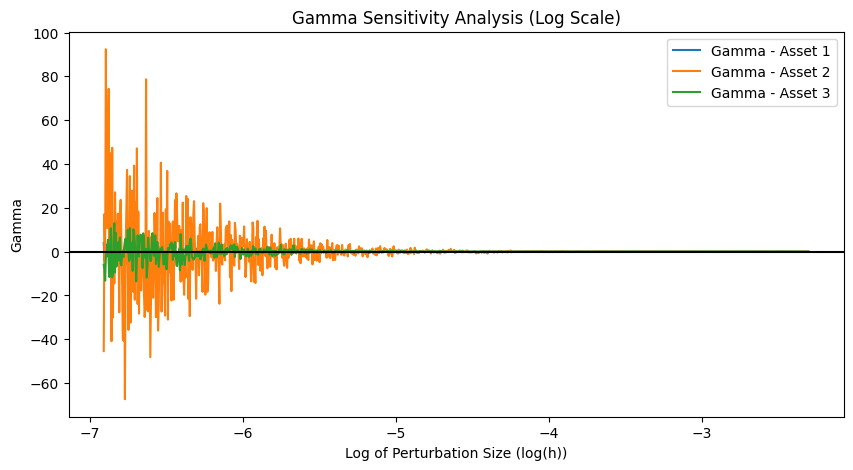

In [20]:
# Plot Delta in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")

plt.xlabel("Perturbation Size (h)")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Delta in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Perturbation Size (h)")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()